In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


  0%|          | 0/150 [00:00<?, ?it/s]

Training 101
torch.Size([1, 2, 59, 105]) torch.Size([1, 2, 88, 157]) torch.Size([1, 2, 118, 210])


/home/liam/.virtualenvs/p36/lib/python3.6/site-packages/torch/nn/functional.py:2533: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


cost -0.013652414083480835


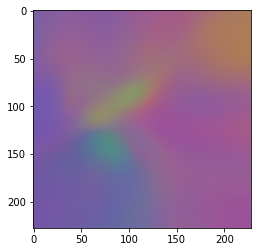

  7%|▋         | 10/150 [00:04<00:51,  2.70it/s]

cost -0.07142437994480133


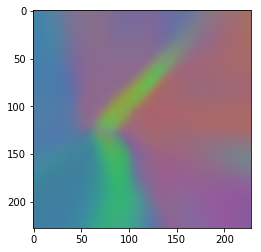

 13%|█▎        | 20/150 [00:07<00:30,  4.30it/s]

cost -0.10209573805332184


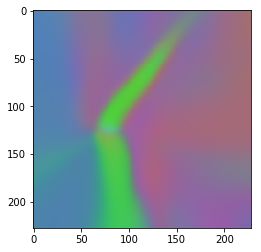

 20%|██        | 30/150 [00:09<00:27,  4.40it/s]

cost -0.13283079862594604


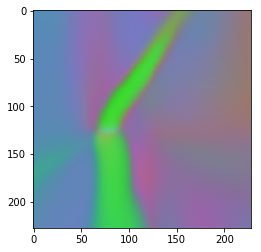

 27%|██▋       | 40/150 [00:11<00:24,  4.41it/s]

cost -0.12398884445428848


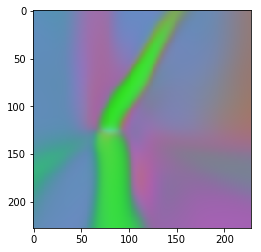

 33%|███▎      | 50/150 [00:14<00:22,  4.41it/s]

cost -0.16324558854103088


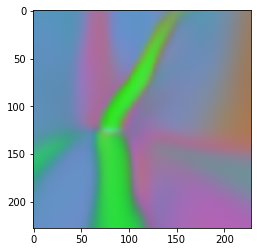

 40%|████      | 60/150 [00:16<00:20,  4.41it/s]

cost -0.17290639877319336


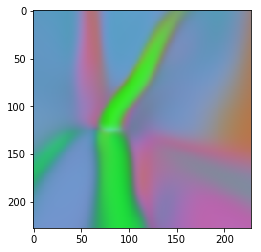

 47%|████▋     | 70/150 [00:18<00:18,  4.40it/s]

cost -0.2023763209581375


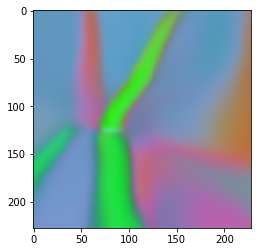

 53%|█████▎    | 80/150 [00:21<00:15,  4.40it/s]

cost -0.2196587324142456


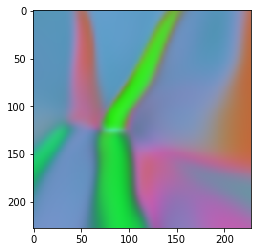

 60%|██████    | 90/150 [00:23<00:13,  4.40it/s]

cost -0.2283433973789215


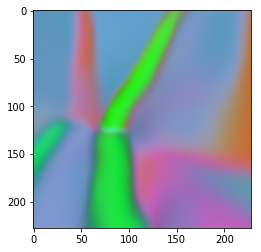

 67%|██████▋   | 100/150 [00:25<00:11,  4.40it/s]

cost -0.2317027896642685


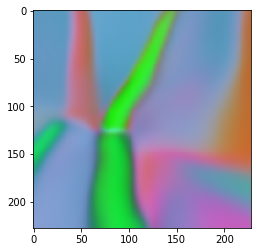

 73%|███████▎  | 110/150 [00:28<00:09,  4.40it/s]

cost -0.24773475527763367


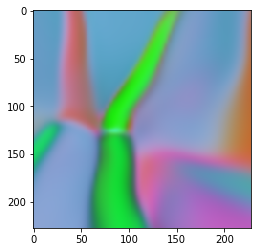

 80%|████████  | 120/150 [00:30<00:06,  4.40it/s]

cost -0.24244701862335205


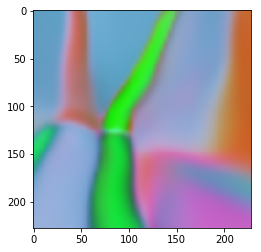

 87%|████████▋ | 130/150 [00:33<00:04,  4.43it/s]

cost -0.26627790927886963


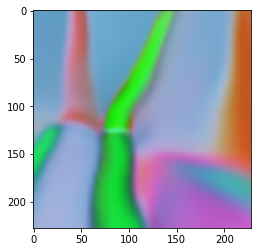

 93%|█████████▎| 140/150 [00:35<00:02,  4.39it/s]

cost -0.2778546214103699


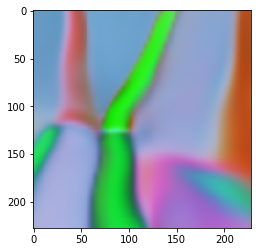

  0%|          | 0/50 [00:00<?, ?it/s]

Changed learning rate to 0.0001
cost -0.31122803688049316


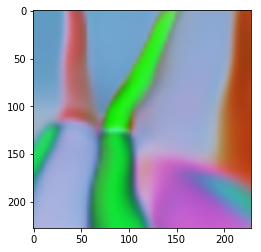

 20%|██        | 10/50 [00:02<00:09,  4.19it/s]

cost -0.3182888329029083


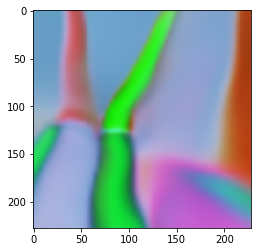

 40%|████      | 20/50 [00:04<00:06,  4.38it/s]

cost -0.31618189811706543


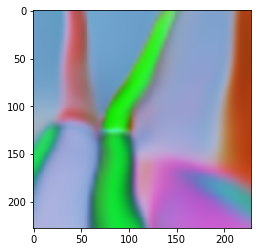

 60%|██████    | 30/50 [00:07<00:04,  4.39it/s]

cost -0.30684608221054077


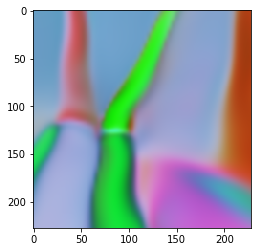

 80%|████████  | 40/50 [00:09<00:02,  4.39it/s]

cost -0.30140313506126404


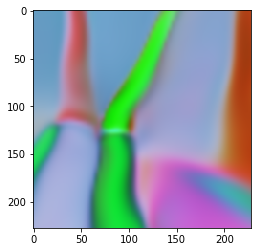

100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Took 49.66773867607117 seconds
Saving 101
Took 0.19823122024536133 seconds


In [2]:
import time
from skimage.io import imsave
from dreamz.utils import get_latest_filename, tch_im_to_np
from dreamz.cppn import get_xy_mesh, CPPNNet, UpsampleNet
from dreamz.render import train_visualiser
from dreamz.torch_utils import Lambda, adjust_learning_rate
from dreamz.cppn import composite_activation
import torch
from torch import nn
from torchvision import models
from torch.nn import functional as F
from torch import optim
import numpy as np



def train(size, widths, imagenet_model, chan_to_opt, log_interval):
    base = CPPNNet(widths)
    viz = UpsampleNet(base, reps=1).to(device)
    viz = nn.DataParallel(viz)
    mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
    std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

    def imgnet_objective(output, _):
        r = imagenet_model((output - mean) / std)
    #     return torch.mean((r - targ) ** 2)
        return -r[:, chan_to_opt].mean()

    xy = get_xy_mesh(size).to(device)
    xy2 = get_xy_mesh([int(i * 1.5) for i in size]).to(device)
    xy4 = get_xy_mesh([int(i * 2.0
                          ) for i in size]).to(device)
    print(xy.shape, xy2.shape, xy4.shape)

    def im_gen_fn(pct_done=0.0, num=64):
        xy_crop = []
        h, w = size
        for i in range(num):
            r = np.random.rand()
            if i == 0:
                x0, x1 = 30, 30 + h
                xy_crop.append(xy[:, :, :, x0:x1])
            elif r < 0.2:
                x0 = np.random.choice([0, w - h])
                x1 = x0 + h
                xy_crop.append(xy[:, :, :, x0:x1])
            elif r < 0.6:
                x0 = np.random.randint(0, xy2.shape[3] - h)
                x1 = x0 + h
                y0 = np.random.randint(0, xy2.shape[2] - h)
                y1 = y0 + h
                xy_crop.append(xy2[:, :, y0:y1, x0:x1])
            else:
                x0 = np.random.randint(0, xy4.shape[3] - h)
                x1 = x0 + h
                y0 = np.random.randint(0, xy4.shape[2] - h)
                y1 = y0 + h
                xy_crop.append(xy4[:, :, y0:y1, x0:x1])
                
        xy_crop = torch.cat(xy_crop, 0)
        return viz(xy_crop), None
    opt = optim.Adam(viz.parameters(), lr=0.001)
    train_visualiser(imgnet_objective, im_gen_fn, opt, iters=150, log_interval=log_interval)
    adjust_learning_rate(opt, 0.1)
    train_visualiser(imgnet_objective, im_gen_fn, opt, iters=50, log_interval=log_interval)
    return viz


def get_imagenet_model():
#     model = models.resnet18(pretrained=True)
    model = models.resnet50(pretrained=True)
#     model = nn.Sequential(*(
#         [i for i in model.children()][:-2] + [
#             nn.AdaptiveAvgPool2d(output_size=(1, 1)),
#             Lambda(lambda x: x[:, :, 0, 0])]))
    model = nn.Sequential(*(
        [i for i in model.children()][:-3] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
    return model.eval()


device = 'cuda'
ims_savedir = '../data/output_ims3/'
widths = [30] * 8
size = [59, 105]

imagenet_model = get_imagenet_model().to(device)
imagenet_model = nn.DataParallel(imagenet_model)

chan_to_opt = 101
log_interval = 10

now = time.time()
print('Training {}'.format(chan_to_opt))
viz = train(size, widths, imagenet_model, chan_to_opt, log_interval)
print('Took {} seconds'.format(time.time() - now))
now = time.time()
print('Saving {}'.format(chan_to_opt))
xy_big = get_xy_mesh([277, 502]).to(device)
res = viz(xy_big)
# imsave(get_latest_filename(ims_savedir), tch_im_to_np(res))
print('Took {} seconds'.format(time.time() - now))


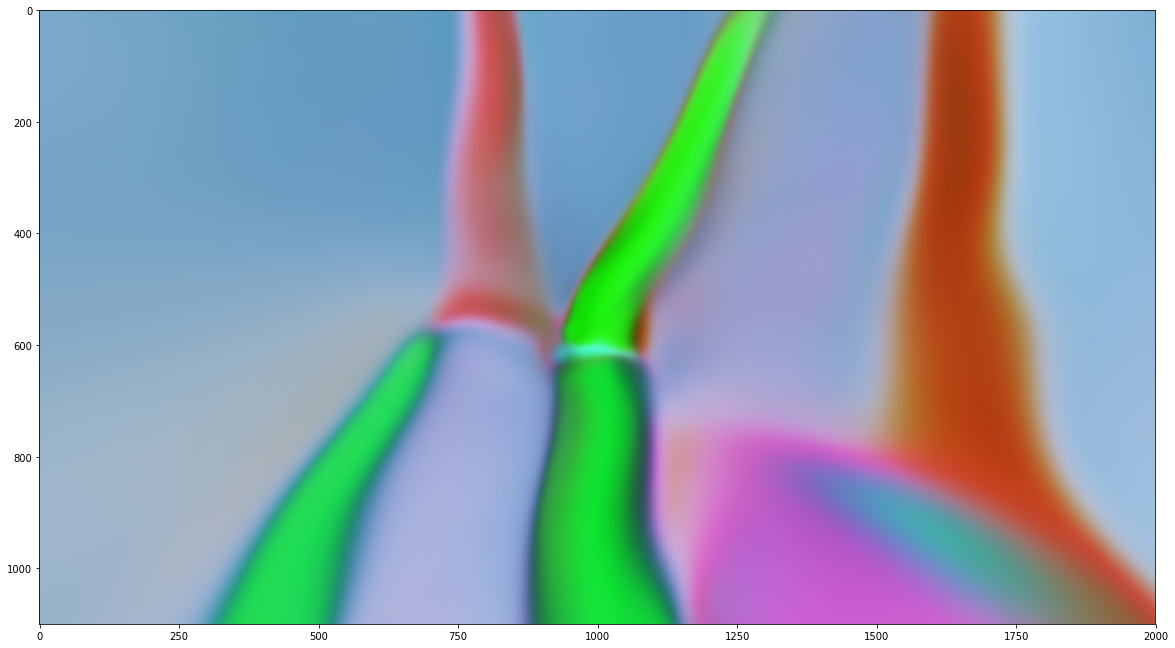

In [4]:
plt.figure(figsize=[20]*2)
plt.imshow(tch_im_to_np(res))
plt.show()